In [1]:
!python -m pip install import-ipynb




[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Metric | System | Normalized Mean Cost | Policy Consistency
-----------------------------------------------------------
NNQ | 3-queues | 1.000 | 100.0%
AMQ1 | 3-queues | 1.005 | 99.5%
AMQ2 | 3-queues | 1.000 | 99.4%
NNQ | 6-queues | 1.000 | 100.0%
AMQ1 | 6-queues | 0.999 | 99.3%
AMQ2 | 6-queues | 1.004 | 99.5%


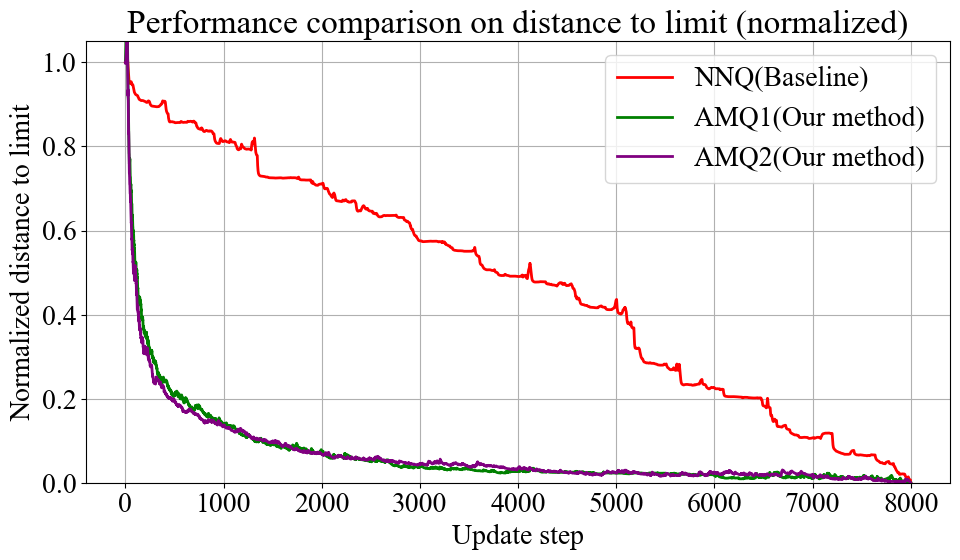

In [2]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

enfont = {'family': 'Times New Roman', 'weight' : 'normal', 'size': 21}

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 20
import import_ipynb

# Import Q modules
import RL_attacker_polling_nn as ctrl_mod  # NNQ
import RL_attacker_polling_AMQ1 as exp_mod_AMQ1  # AMQ1
import RL_attacker_polling_AMQ2 as exp_mod_AMQ2  # AMQ2

def compute_policy_consistency(ctrl_hist, exp_hist):
    if len(ctrl_hist) == 0 or len(exp_hist) == 0:
        return 0.0
    mean_b_ctrl = float(np.mean([rec['b'] for rec in ctrl_hist]))
    mean_b_exp = float(np.mean([rec['b'] for rec in exp_hist]))
    if mean_b_ctrl == 0.0:
        return 1.0 if mean_b_exp == 0.0 else 0.0
    pc = 1.0 - abs(mean_b_exp - mean_b_ctrl) / mean_b_ctrl
    return float(np.clip(pc, 0.0, 1.0))

def norm_curve_from_history(vector_list, max_steps=4000):
    """Compute normalized distance-to-limit curve from a list of parameter vectors."""
    if not vector_list:
        return None, None
    arr = np.array(vector_list[:max_steps])
    final_vec = arr[-1]
    diffs = np.linalg.norm(arr - final_vec, axis=1)
    if diffs[0] == 0:
        norm_diffs = np.zeros_like(diffs)
    else:
        norm_diffs = diffs / diffs[0]
    steps = np.arange(len(norm_diffs))
    return steps, norm_diffs

def plot_param_convergence(sample_hist, max_steps=4000):
    """Plot normalized distance-to-limit for NNQ, AMQ1, AMQ2 on one figure."""
    if sample_hist is None:
        print("No history available for plotting.")
        return

    plt.figure(figsize=(10, 6))

    steps, curve = norm_curve_from_history(sample_hist.get('ctrl_params', []), max_steps=max_steps)
    if steps is not None:
        plt.plot(steps, curve, label='NNQ(Baseline)', color='red', linewidth=2)

    steps, curve = norm_curve_from_history(sample_hist.get('amq1_w', []), max_steps=max_steps)
    if steps is not None:
        plt.plot(steps, curve, label='AMQ1(Our method)', color='green', linewidth=2)

    steps, curve = norm_curve_from_history(sample_hist.get('amq2_w', []), max_steps=max_steps)
    if steps is not None:
        plt.plot(steps, curve, label='AMQ2(Our method)', color='purple', linewidth=2)

    plt.xlabel("Update step")
    plt.ylabel("Normalized distance to limit")
    plt.title("Performance comparison on distance to limit (normalized)")
    plt.ylim(0.0, 1.05)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def simulate_triplet(queue_nums, num_runs=10, sim_time=2000.0, return_hist=False):
    ctrl_rewards, amq1_rewards, amq2_rewards = [], [], []
    policy_consistencies_amq1, policy_consistencies_amq2 = [], []
    sample_hist = None

    for run in range(num_runs):
        seed_base = 1000 + run
        if queue_nums == 3:
            arrival_rates = [5.0, 5.0, 5.0]
            service_rate = 25.0
        elif queue_nums == 6:
            arrival_rates = [2.0, 2.0, 3.0, 3.5, 2.0, 3.0] #[2.0, 3.0, 3.0, 4.0, 2.0, 3.0]
            service_rate = 29.0
        else:
            arrival_rates = [3.6] * queue_nums
            service_rate = 25.0
        ini_jobs_list = [10] * queue_nums

        # NNQ baseline
        np.random.seed(seed_base)
        ctrl_sys = ctrl_mod.PollingSystem(
            queue_nums=queue_nums,
            arrival_rates=arrival_rates,
            ini_jobs_list=ini_jobs_list,
            service_rate=service_rate,
            switch_time=0.1,
            simulation_time=sim_time,
        )
        ctrl_sys.run_simulation()

        # AMQ1 training + fixed policy
        np.random.seed(seed_base ** 2)
        amq1_train = exp_mod_AMQ1.PollingSystem(
            queue_nums=queue_nums,
            arrival_rates=arrival_rates,
            ini_jobs_list=ini_jobs_list,
            service_rate=service_rate,
            switch_time=0.1,
            simulation_time=sim_time,
        )
        amq1_train.run_simulation()
        optimal_wk_amq1 = amq1_train.rl_history[-1]["w"]

        amq1_sys = exp_mod_AMQ1.PollingSystemWithFixedPolicy(
            queue_nums=queue_nums,
            arrival_rates=arrival_rates,
            ini_jobs_list=ini_jobs_list,
            service_rate=service_rate,
            switch_time=0.1,
            simulation_time=sim_time,
            optimal_wk=optimal_wk_amq1,
        )
        amq1_sys.run_simulation_with_fixed_policy()

        # AMQ2 training + fixed policy
        np.random.seed(seed_base ** 3)
        amq2_train = exp_mod_AMQ2.PollingSystem(
            queue_nums=queue_nums,
            arrival_rates=arrival_rates,
            ini_jobs_list=ini_jobs_list,
            service_rate=service_rate,
            switch_time=0.1,
            simulation_time=sim_time,
        )
        amq2_train.run_simulation()
        optimal_wk_amq2 = amq2_train.rl_history[-1]["w"]

        amq2_sys = exp_mod_AMQ2.PollingSystemWithFixedPolicy(
            queue_nums=queue_nums,
            arrival_rates=arrival_rates,
            ini_jobs_list=ini_jobs_list,
            service_rate=service_rate,
            switch_time=0.1,
            simulation_time=sim_time,
            optimal_wk=optimal_wk_amq2,
        )
        amq2_sys.run_simulation_with_fixed_policy()

        # metrics per run
        ctrl_rewards.append(np.mean([rec['R_k1'] for rec in ctrl_sys.rl_history]))
        amq1_rewards.append(np.mean([rec['R_k1'] for rec in amq1_sys.rl_history]))
        amq2_rewards.append(np.mean([rec['R_k1'] for rec in amq2_sys.rl_history]))

        policy_consistencies_amq1.append(compute_policy_consistency(ctrl_sys.rl_history, amq1_sys.rl_history))
        policy_consistencies_amq2.append(compute_policy_consistency(ctrl_sys.rl_history, amq2_sys.rl_history))

        if return_hist and sample_hist is None:
            sample_hist = {
                'ctrl_params': [rec['params'] for rec in ctrl_sys.rl_history],
                'amq1_w': [rec['w'] for rec in amq1_train.rl_history],
                'amq2_w': [rec['w'] for rec in amq2_train.rl_history],
            }

    ctrl_reward_mean = float(np.mean(ctrl_rewards))
    amq1_reward_mean = float(np.mean(amq1_rewards))
    amq2_reward_mean = float(np.mean(amq2_rewards))
    amq1_policy_consistency = float(np.mean(policy_consistencies_amq1))
    amq2_policy_consistency = float(np.mean(policy_consistencies_amq2))

    return (
        ctrl_reward_mean,
        amq1_reward_mean,
        amq1_policy_consistency,
        amq2_reward_mean,
        amq2_policy_consistency,
        sample_hist,
    )

def generate_comparison_table():
    table = []
    sample_hist = None

    for queue_nums in [3, 6]:
        ctrl_reward, amq1_reward, amq1_pc, amq2_reward, amq2_pc, hist = simulate_triplet(
            queue_nums, num_runs=10 , sim_time=2000.0, return_hist=(sample_hist is None)
        )

        if sample_hist is None:
            sample_hist = hist

        table.append([
            'NNQ', queue_nums,
            1.0,
            100.0,
        ])

        reward_norm_amq1 = abs(amq1_reward / ctrl_reward) if ctrl_reward != 0 else float('nan')
        table.append([
            'AMQ1', queue_nums,
            reward_norm_amq1,
            amq1_pc * 100.0,
        ])

        reward_norm_amq2 = abs(amq2_reward / ctrl_reward) if ctrl_reward != 0 else float('nan')
        table.append([
            'AMQ2', queue_nums,
            reward_norm_amq2,
            amq2_pc * 100.0,
        ])

    print("Metric | System | Normalized Mean Cost | Policy Consistency")
    print("-----------------------------------------------------------")
    for method, queue_nums, mean_reward, mean_pc in table:
        print(f"{method} | {queue_nums}-queues | {mean_reward:.3f} | {mean_pc:.1f}%")

    return sample_hist

if __name__ == "__main__":
    hist = generate_comparison_table()
    plot_param_convergence(hist, max_steps=8000)
